___
this notebook select features that are important before throwing into the model

In [61]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.feature_selection import *
from sklearn import *
from scipy import *
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from aggregate_function import build_features_table, combine_features_table, coach_stats, win_rate_type_of_location

In [2]:
coach_file = 'data/DataFiles/TeamCoaches.csv'
regularseason_file = 'data/DataFiles/RegularSeasonDetailedResults.csv'
postseason_file = 'data/DataFiles/NCAATourneyCompactResults.csv'

In [3]:
initial_features = build_features_table.BuildFeaturesTable(regularseason_file)
win_rate_features = win_rate_type_of_location.WinRateTypeLocation(regularseason_file)
coach_features = coach_stats.CoachStats(coach_file,regularseason_file,postseason_file)

features = combine_features_table.CombineFeaturesTable(initial_features,win_rate_features,coach_features)

## Feature Selection on Correlation Matrix
- remove features that are highly correlated

In [4]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID'],1)
)

corr = features_table.corr()
# features_table.corr(method='pearson').to_csv("correlation_matrix.csv")

columns to be excluded
- total score
- total rebounds
- total blocks
- total assist turnover ratio
- E(X) per game
- win rate
- total rebound possession per game
- win_rate_overall coach

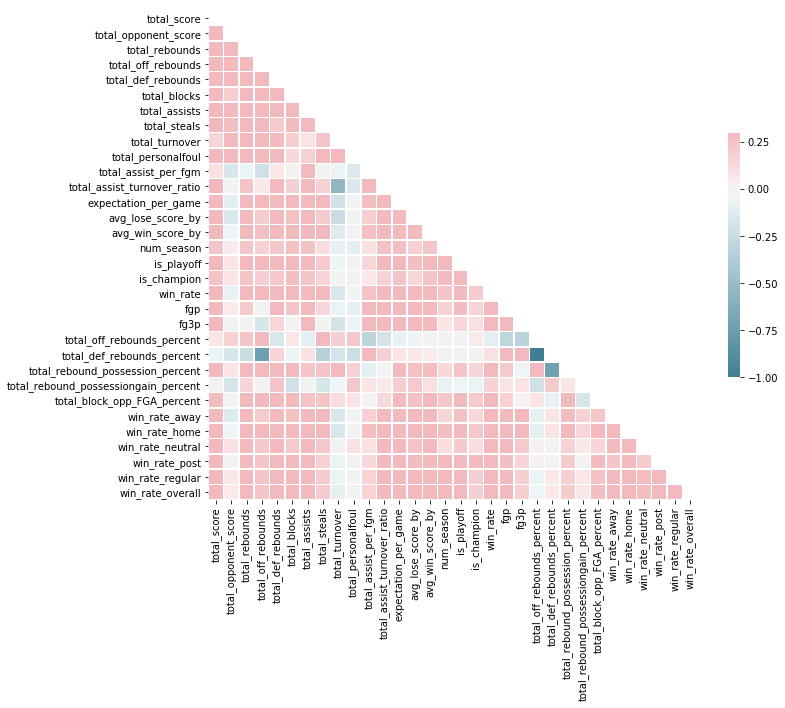

In [6]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [49]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID','total_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','total_rebound_possession_percent','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent'
          ],1)
    .fillna(0)
)

## Feature selection from collinearity
- remove features that are collinearity
- features are then passed through variance threshold before passing into models for feature selection

In [51]:
vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns

features to further remove
- total_opponent_score
- total_rebound_possessiongain_percent 
- fg3p

In [57]:
features_table = (
    features.final_table_processed
    .drop(['Season','TeamID','total_score','total_rebounds','total_blocks','total_assist_turnover_ratio','expectation_per_game',
           'win_rate','total_rebound_possession_percent','win_rate_overall','total_off_rebounds_percent','total_def_rebounds_percent',
           'total_opponent_score','total_rebound_possessiongain_percent','fg3p'
          ],1)
    .fillna(0)
)

vif = pd.DataFrame()
vif['VIF_factor'] = [variance_inflation_factor(features_table.values, i) for i in range(features_table.shape[1])]
vif['features'] = features_table.columns
vif

,VIF_factor,features
0,36.415864,total_off_rebounds
1,103.802673,total_def_rebounds
2,110.108976,total_assists
3,23.265132,total_steals
4,50.939935,total_turnover
5,57.534110,total_personalfoul
6,34.100459,total_assist_per_fgm
7,55.141142,avg_lose_score_by
8,19.403385,avg_win_score_by
9,5.904228,num_season


## Feature selection from PCA explained variance
- use PCA to see how much variance does the feature account for, selecting up to 98% variance would be good enough
- 12 features are enough for variance
    - this doesnt tell us which features to discard but in the model selection of feature importance
    - we can tell the model to choose up to 12 features max

In [66]:
covar_matrix = PCA(n_components = 19)

covar_matrix.fit(features_table)
variance = covar_matrix.explained_variance_ratio_ #calculate variance ratios

var=np.cumsum(np.round(covar_matrix.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features

array([ 41.4,  56.9,  66.1,  74.1,  79.6,  84.5,  88.8,  91.3,  93.2,
        94.7,  95.9,  97. ,  98. ,  98.8,  99.4,  99.7, 100. , 100. , 100. ])

## 